## Rotating the object (and the xy-axes).

This has the following effects (for counterclockwise/positive $\Delta\omega$):
1. Probe beam ($\mathbf{k_i})$ angle becomes less than $2\theta$ (wrt y-axis).
2. Exit wave ($\mathbf{k_f})$ angle becomes greater than 0 (wrt y-axis).

In [1]:
import helper
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage, io
import tensorflow as tf

In [3]:
%load_ext autoreload
%autoreload 2

## Forward model

In [4]:
cell_orig = np.load('cell_faceted_2.npy')#, (1,0,2))
cell_orig.shape

(28, 58, 62)

In [5]:
cell_padded = np.pad(cell_orig, [[18, 18],[52, 52],[25, 25]], mode='constant') * 0.5
cell_padded.shape

(64, 162, 112)

In [6]:
nonzero_indices = np.transpose(np.where(np.abs(cell_padded) > 0))
raveled_indices = np.ravel_multi_index(nonzero_indices.T, cell_padded.shape)
nonzero_vals = cell_padded.flatten()[raveled_indices]

cell_padded_temp = np.zeros(cell_padded.size, dtype='complex64')
cell_padded_temp[raveled_indices] = nonzero_vals * np.exp(-1j * scipy.stats.circmean(np.angle(nonzero_vals)))
cell_padded = cell_padded_temp.reshape(cell_padded.shape)

In [7]:
cell_shape = cell_padded.shape

energy = 8 # keV
wavelength = 1.239e-9 / energy # compliant with E = hc / wavelength
n_photons = 1e4

pixel_pitch = 55e-6 # [m]
distance_f_d_ptycho = 1.5 # \in IR  sample to camera distance [m]

probe_yz_npix = 64
two_theta_bragg = 60 * np.pi / 180
omega_cen = 0.5 * two_theta_bragg

delta_omega =  0.25 * 0.5 * 0.09 * np.pi / 180# \in IR  : Angle step-size in the RC  [rad]
delta_omega = 0.02 * np.pi / 180
number_pos_rc = 15

n_det_pix_x = 64
n_det_pix_z = 64

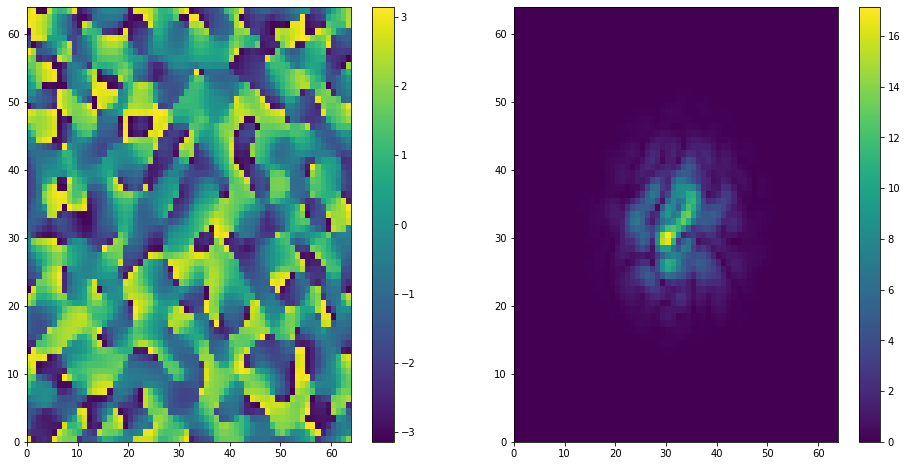

In [8]:
probe_yz = helper.getGaussian2D(probe_yz_npix, stdev=6)
speckle = helper.getSpeckle(probe_yz_npix, 20)
probe_yz = speckle * probe_yz 
probe_yz = probe_yz * np.sqrt(n_photons / np.sum(np.abs(probe_yz)**2))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=[16,8])
mesh = ax1.pcolormesh(np.angle(probe_yz))
plt.colorbar(mesh, ax=ax1)
mesh2 = ax2.pcolormesh(np.abs(probe_yz))
plt.colorbar(mesh2, ax=ax2)
plt.show()

In [41]:
# Generating the 3d probe
# 1. assume that the probe does not vary along the x-direction
# 2. repeat the y-z probe structure required number of times (trial and error)
# 3. rotate and interpolate
probe_3d = np.repeat(probe_yz[None, :,:], 111, axis=0)

rotate_angle = (np.pi/2 - two_theta_bragg) * 180 / np.pi
probe_rotated = (ndimage.rotate(np.real(probe_3d), rotate_angle, axes=(0, 1), mode='constant',order=1 ) + 
                 1j * ndimage.rotate(np.imag(probe_3d), rotate_angle, axes=(0, 1), mode='constant',order=1))
print(probe_rotated.shape)

(128, 111, 64)


(128, 111, 64) (64, 80, 64)


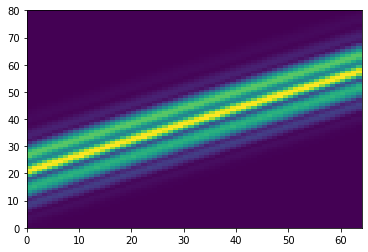

In [42]:
# Plot xy probe profile
probe_rotated_centered = probe_rotated[32:96,16:96]
print(probe_rotated.shape, probe_rotated_centered.shape)

plt.pcolormesh(np.abs(probe_rotated_centered[:,:,32].T), cmap='viridis')
plt.show()

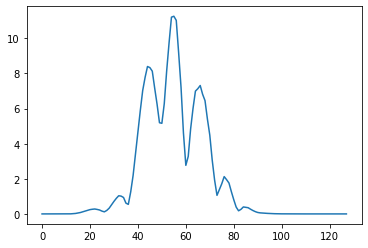

[0. 0. 0. 0.]


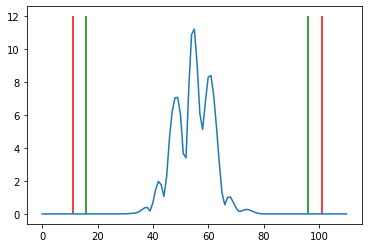

In [43]:
# Chcek to see if we completely capture the probe structure (in y-direction) within only 80 pixels (instead of 111 pix)
# This reduces the storage and computation requirement somewhat
plt.plot(np.abs(probe_rotated[:,50,32]))
plt.show()
plt.plot(np.abs(probe_rotated[63,:,32]))
print(np.abs(probe_rotated[63,:,32][[11,16,96,101]]))
plt.vlines([11,101], ymin=0, ymax=12, color='red')
plt.vlines([16,96], ymin=0, ymax=12, color='green')
plt.show()

In [44]:
# Calculate the wave vectors for each rocking-curve (rc) angle

ki = 2 * np.pi / wavelength * np.array([np.sin(two_theta_bragg), np.cos(two_theta_bragg), 0])
kf = 2 * np.pi / wavelength * np.array([0, 1, 0])
q = (kf - ki)[:,None]

rc_angles = np.arange(-delta_omega * (number_pos_rc - 1) / 2,
                      delta_omega * (number_pos_rc) / 2, 
                      delta_omega)

ki_new = 2 * np.pi / wavelength * np.array([np.sin(two_theta_bragg + rc_angles),
                                            np.cos(two_theta_bragg + rc_angles),
                                            0 * rc_angles])
kf_new = 2 * np.pi / wavelength * np.array([np.sin(rc_angles),
                                            np.cos(rc_angles),
                                            0 * rc_angles])
q_new = kf_new - ki_new

delta_q = q_new - q
delta_q1, delta_q2, delta_q3 = delta_q

In [45]:
# Using a 64x64 pixel detector, calculate the pixel size in real space
object_plane_support_size = wavelength * distance_f_d_ptycho / pixel_pitch
dr1 = object_plane_support_size / n_det_pix_x
dr2 = object_plane_support_size / n_det_pix_x
dr3 = object_plane_support_size / n_det_pix_z

In [46]:
# Total probe dimensions in real space.
total_length_r1 = dr1 * probe_rotated_centered.shape[0]
total_length_r2 = dr2 * probe_rotated_centered.shape[1]
total_length_r3 = dr3 * probe_rotated_centered.shape[2]

In [47]:
total_length_r1, total_length_r2, total_length_r3, dr1, dr2, dr3, dr1 * 3, object_plane_support_size

(4.2238636363636365e-06,
 5.279829545454546e-06,
 4.2238636363636365e-06,
 6.599786931818182e-08,
 6.599786931818182e-08,
 6.599786931818182e-08,
 1.9799360795454546e-07,
 4.2238636363636365e-06)

In [48]:
# This is to calculate the phase ramp

r1 = np.arange(-total_length_r1 / 2, total_length_r1 / 2, dr1)
r2 = np.arange(-total_length_r2 / 2, total_length_r2 / 2, dr2)
r3 = np.arange(-total_length_r3 / 2, total_length_r3 / 2, dr3)

R1, R2, R3 = np.meshgrid(r1, r2, r3, indexing='ij')

In [49]:
R1.shape, R2.shape, R3.shape

((64, 80, 64), (64, 80, 64), (64, 80, 64))

In [50]:
probe_rotated_centered.shape, cell_padded.shape

((64, 80, 64), (64, 162, 112))

In [52]:
# Calculate the diffraction patterns 
# the "modulation" term captures the phase ramp per rc angle.
# 

step_npix_y = 2
step_npix_z = 2
cell_npix_p, cell_npix_r, cell_npix_c = cell_padded.shape
probe_shape = probe_rotated_centered.shape

grid_positions_r = np.arange(0, cell_npix_r - probe_shape[1], step_npix_y)
grid_positions_c = np.arange(0, cell_npix_c - probe_shape[2], step_npix_z)

diffraction_intensities_temp = []
positions = []
angles = []

for i_angle in range(number_pos_rc):
    modulation = np.exp(1j * (delta_q3[i_angle] * R3 + delta_q2[i_angle] * R2 + delta_q1[i_angle] * R1))
    for c in grid_positions_c:
        for r in grid_positions_r:
            exit_wave = cell_padded[:, r: r + probe_shape[1], c: c + probe_shape[2] ] * probe_rotated_centered * modulation
            
            exit_wave_proj = np.sum(exit_wave, axis=1)
            
            # If the probe x-z dimensions are smaller than the detector dimensions, then we pad the exit wave
            # to get the required 64x64 diffraction patterns.
            exit_wave_proj_padded = np.pad(exit_wave_proj,
                                           [[(n_det_pix_x - cell_npix_p)//2, (n_det_pix_x - cell_npix_p)//2],
                                           [(n_det_pix_z - probe_shape[2])//2, (n_det_pix_z - probe_shape[2]) // 2]], 
                                           mode='constant')
            exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave_proj_padded, 
                                                       norm='ortho', 
                                                       axes=(0,1)), 
                                           axes=(0,1))
            diff_temp = np.abs(exit_wave_ft)**2
            diffraction_intensities_temp.append(diff_temp)
            positions.append([r, c])
            angles.append(i_angle)


diffraction_intensities = np.array(diffraction_intensities_temp).astype('float32')

# Adding poisson noise
diffraction_intensities = np.random.poisson(diffraction_intensities).astype('float32')
positions = np.array(positions)
angles = np.array(angles)

In [54]:
ndiffs, npix_r, npix_c = diffraction_intensities.shape
print("cell shape", cell_shape, "diffs", diffraction_intensities.shape, diffraction_intensities.max())

cell shape (64, 162, 112) diffs (14760, 64, 64) 17521.0


In [55]:
# Calculating the phase modulations (or ramp) per ptychography scan position.
positions_unique = np.unique(positions, axis=0)
positions_indices = []
for pos in positions:
    positions_indices.append(np.argmin(np.linalg.norm(pos - positions_unique, axis=-1)))
    
modulations_all = np.exp(np.array([delta_q1[i] * R1 
                                   + delta_q2[i] * R2 
                                   + delta_q3[i] * R3
                                   for i in range(number_pos_rc)]) * 1j)

# Index the object pixels accessed at each ptychogrpahic scan position
view_indices_all =helper.getViewIndices3d(cell_padded, 
                                          positions_unique, 
                                          probe_shape[1], 
                                          probe_shape[2]).astype('int32')

## Reconstruction: 

In [56]:
# Define the 3d shape for the object variable
# We assume we have prior information about the maximum x-extent of the sample.
# Padding of 2 pixels in the x-direction allows for any errors introduced by poisson noise.
# Padding of 20 pixels in the y and z directions show that we have limited information about
# the sample size in y and z directions.

shape_new = np.array(cell_orig.shape) + np.array([2,20,20])
obj_init = np.random.randn(*shape_new)* np.exp(1j * 2 * np.pi * np.random.randn(*shape_new))
final_shape = cell_orig.shape

pad_vals = (np.array(cell_padded.shape) - np.array(obj_init.shape))//2
pad_vals, cell_padded.shape, obj_init.shape

(array([17, 42, 15]), (64, 162, 112), (30, 78, 82))

In [57]:
var_true = np.pad(cell_orig, [[1,1],[10,10],[10,10]], mode='constant')
#obj_init = var_true.copy()
var_true.shape

(30, 78, 82)

In [27]:
simulation_params = {'cell_orig_shape':(np.array(cell_orig.shape)-2).astype('int'),
                     'cell_padded_shape':cell_padded.shape,
                     'energy':energy,
                     'wavelength':wavelength,
                     'n_probe_photons':n_photons,
                     'det_pixel_pitch':pixel_pitch,
                     'distance_f_d_ptycho':distance_f_d_ptycho,
                     'probe_yz_npix':probe_yz_npix,
                     'two_theta_bragg':two_theta_bragg,
                     'omega_cen':omega_cen,
                     'delta_omega':delta_omega,
                     'number_pos_rc':number_pos_rc,
                     'n_det_pix_x':n_det_pix_x,
                     'n_det_pix_z':n_det_pix_z,
                     'step_npix_y':step_npix_y,
                     'step_npix_z':step_npix_z,
                     'raster_grid_num_y':grid_positions_r.size,
                     'raster_grid_num_z':grid_positions_c.size,
                     'probe_shape':probe_rotated_centered.shape,
                    }

In [28]:
np.save('simulation_params.npy', simulation_params)

### Starting the tensorflow recons

In [58]:
tf.reset_default_graph()
with tf.device('/gpu:0'):
    tf_diffs = tf.constant(diffraction_intensities, dtype='float32')
    tf_angles = tf.constant(angles, dtype='int32')
    
    tf_positions_indices = tf.constant(positions_indices, dtype='int32')
    tf_views_indices_all = tf.constant(view_indices_all, dtype='int32')

    tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
    tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')
    tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

    tf_probe = tf.constant(probe_rotated_centered, dtype='complex64')
    tf_modulations_all = tf.constant(modulations_all, dtype='complex64')
    probe_npix = probe_rotated_centered.shape[1]    

In [59]:
# Padding the object variable to get the simulation box. 
# The object variable is placed at the center of the simulation box.
tf_obj_padded = tf.pad(tf_obj, [[pad_vals[0], pad_vals[0]],[pad_vals[1], pad_vals[1]],[pad_vals[2],pad_vals[2]]])
tf_obj_padded

<tf.Tensor 'Pad:0' shape=(64, 162, 112) dtype=complex64>

In [60]:
# Setting up the minibatches.

dataset_indices = tf.data.Dataset.range(angles.shape[0])
dataset_indices_shuffled = dataset_indices.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=ndiffs))

In [61]:
#This is a somewhat complicated way to set up the minibatches
# The advantages are:
# 1) this way I know exactly which ptychographic positions are included in each minibatch
# 2) if we don't use the batch_indices_var variable to temporarily store the minibatch information,
#    then we get a new minibatch from the iterator every time we access the iterator.
#    I found this annoying during debugging.

batch_size = 400
dataset_batch = dataset_indices_shuffled.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
dataset_batch = dataset_batch.prefetch(2)

iterator = dataset_batch.make_one_shot_iterator()
batch_indices = iterator.get_next()
batch_indices_var = tf.Variable(tf.zeros_like(batch_indices), trainable=False)
assign_op = batch_indices_var.assign(batch_indices)

batch_diffs = tf.gather(tf_diffs, batch_indices_var)
batch_positions_indices = tf.gather(tf_positions_indices, batch_indices_var)
batch_view_indices = tf.gather(tf_views_indices_all, batch_positions_indices)
batch_angles = tf.gather(tf_angles, batch_indices_var)
batch_modulations = tf.gather(tf_modulations_all, batch_angles)

In [62]:
# Use the pixel index information to get the actual 3d object slices per scan position
batch_views = tf.gather(tf.reshape(tf_obj_padded, [-1]), batch_view_indices)

In [63]:
# norm_factor is just a scaling factor.
norm_factor = np.product(np.sqrt(diffraction_intensities[0].shape))

# Propagate and apply the projection operator.
exit_waves = batch_views * tf_probe * batch_modulations
exit_waves_proj = tf.reduce_sum(exit_waves, axis=-2)

In [64]:
# padding is only useful if the number of probe y-z pixels is smaller than the detector 
exit_waves_proj_padded = tf.pad(exit_waves_proj ,
                                [[0,0],
                                 [(n_det_pix_x - cell_npix_p)//2, (n_det_pix_x - cell_npix_p)//2],
                                 [(n_det_pix_z - probe_shape[2])//2, (n_det_pix_z - probe_shape[2])//2]])
exit_waves_fts = helper.batch_fftshift2d(tf.fft2d(exit_waves_proj_padded)) / norm_factor

In [65]:
# Finally the loss function
losses = tf.reduce_mean((tf.abs(exit_waves_fts) - tf.sqrt(batch_diffs))**2)

In [66]:
opt = tf.train.AdamOptimizer(1e-2)
minimize_op = opt.minimize(losses)

In [67]:
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True 
sess_config.allow_soft_placement = True
session = tf.Session(config=sess_config)
init = tf.global_variables_initializer()
session.run(init)
_ = session.run(assign_op)

In [68]:
lossvals = []

In [ ]:
for i in range(1, 100000):
    lossval, _ = session.run([losses, minimize_op])
    session.run(assign_op)

    lossvals.append(lossval)
    
    # Check reconstruction error every epoch
    if (i * batch_size) % (ndiffs * 1) >= batch_size: continue
    roll_old, err_old, phase_old, roll_new, err_new, phase_new =  helper.calcRegistrationError3d(cell_padded, 
                                                                                 session.run(tf_obj_padded))
    print(f'{lossval:2.4g}, {i}, {roll_old}, {err_old:2.4f}, {phase_old:2.4f},' +
          f'{roll_new}, {err_new:2.4f}, {phase_new:2.4f}')
    

In [85]:
#session.run(obj_clip_op)
lossval, pr_obj_var = session.run([losses, tf_obj])
roll, err, phase = myfn.register_translation_3d(pr_obj_var, var_true, 10)
pr_obj_var_2 = pr_obj_var * np.exp(-1j * phase)
pr_obj_var_2 = np.roll(pr_obj_var_2, -roll.astype('int'), axis=(0,1,2))
lossval, roll, err, phase, myfn.register_translation_3d(pr_obj_var_2, var_true, 10)

(0.095495224,
 array([-1., -1.,  0.]),
 0.21285946706811606,
 -0.7844536215716131,
 (array([-0., -0.,  0.]), 0.09433701035349792, -0.03127532462916441))

In [87]:
np.save('reconstructed_faceted_cell_rotated_ki_and_kf_batch_400_stepsize_0.01.npy', pr_obj_var_2)
np.save('probe_gaussian_fwhm_6_speckle_20_yz.npy', probe_yz)
np.save('diffractions_intensities_2_2.npy', diffraction_intensities)
np.save('losses.npy', lossvals)

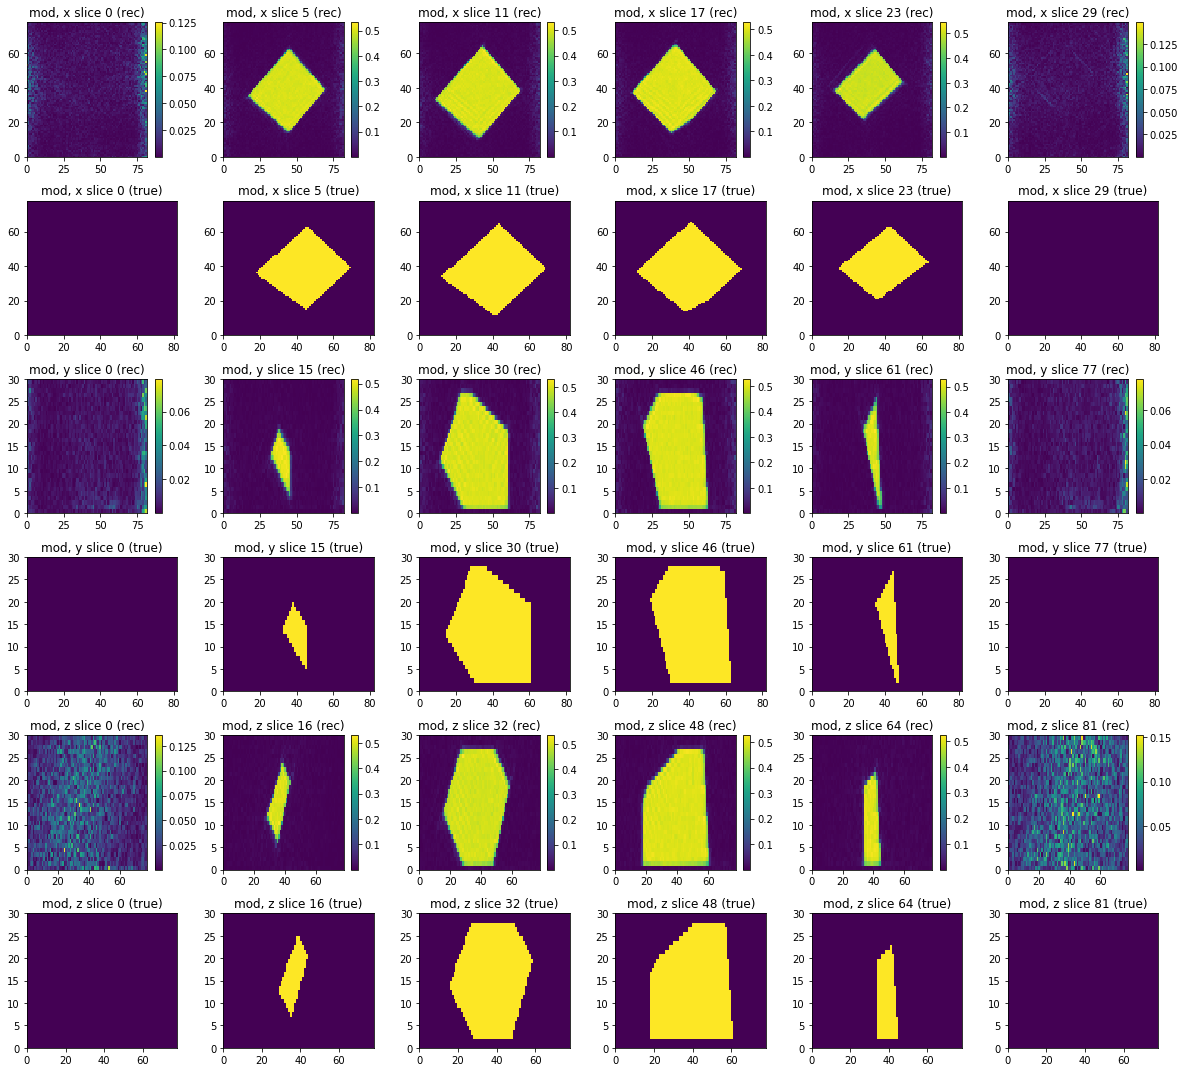

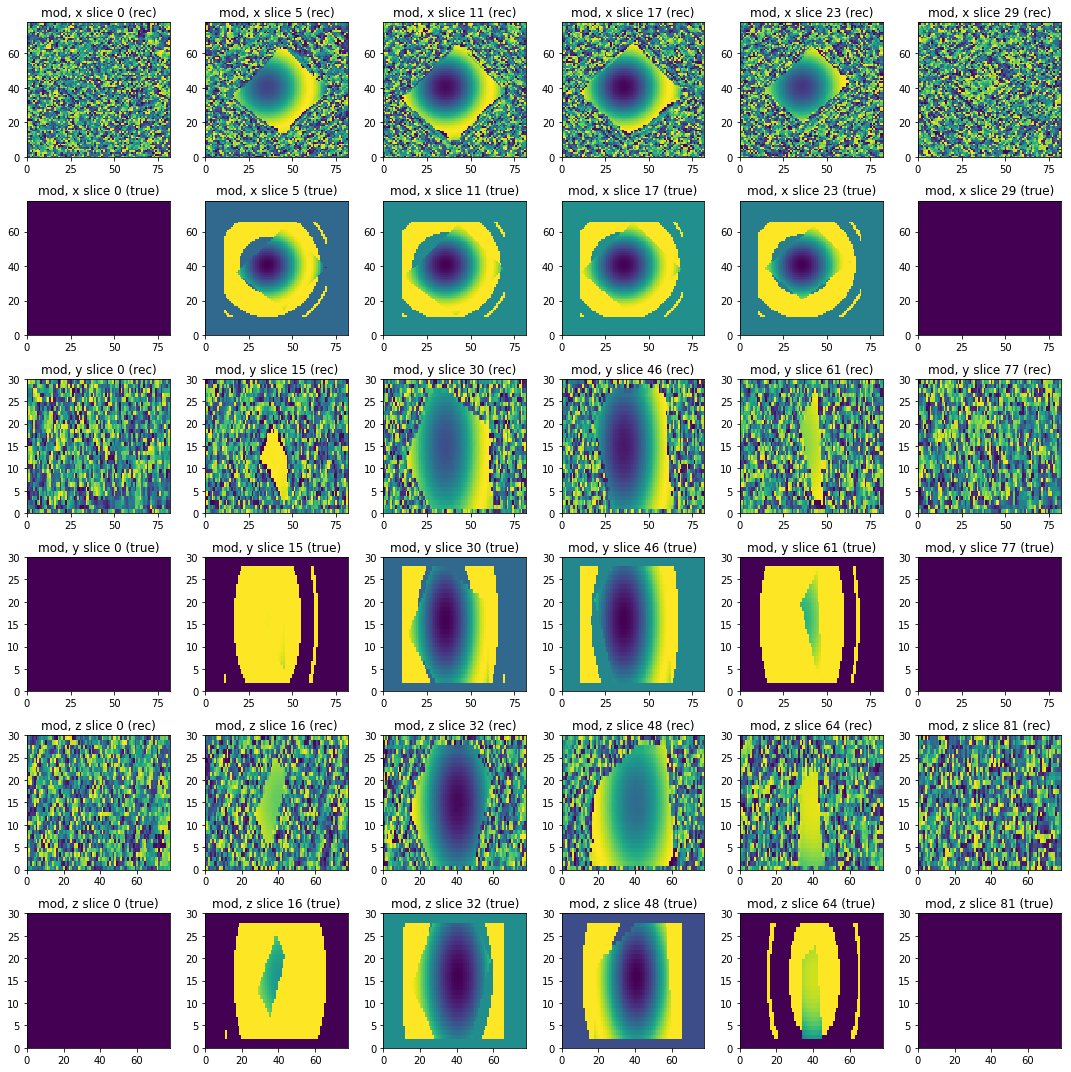

In [88]:
x_slices = np.linspace(0, var_true.shape[0] - 1, 6).astype('int')
y_slices = np.linspace(0, var_true.shape[1] - 1, 6).astype('int')
z_slices = np.linspace(0, var_true.shape[2] - 1, 6).astype('int')

figsize_r = np.max([x_slices.size, y_slices.size, z_slices.size])
plt.figure(figsize=[figsize_r * 2.75, 6 * 2.5])

for indx, x_slice in enumerate(x_slices):
    plt.subplot(6, figsize_r, indx+1)
    plt.pcolormesh(np.abs(pr_obj_var_2[x_slice, :, :]), rasterized=True)
    plt.colorbar()
    plt.title(f'mod, x slice {x_slice} (rec)')
    plt.subplot(6, figsize_r, figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[x_slice, :, :]), rasterized=True)
    plt.title(f'mod, x slice {x_slice} (true)')
    
for indx, y_slice in enumerate(y_slices):
    plt.subplot(6, figsize_r, 2* figsize_r + indx+1)
    plt.pcolormesh(np.abs(pr_obj_var_2[:,y_slice, :]), rasterized=True)
    plt.colorbar()
    plt.title(f'mod, y slice {y_slice} (rec)')
    plt.subplot(6, figsize_r, 3 * figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[:,y_slice, :]), rasterized=True)
    plt.title(f'mod, y slice {y_slice} (true)')
    
for indx, z_slice in enumerate(z_slices):
    plt.subplot(6, figsize_r, 4* figsize_r + indx+1)
    plt.pcolormesh(np.abs(pr_obj_var_2[:,:,z_slice]), rasterized=True)
    plt.colorbar()
    plt.title(f'mod, z slice {z_slice} (rec)')
    plt.subplot(6, figsize_r, 5 * figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[:,:,z_slice]), rasterized=True)
    plt.title(f'mod, z slice {z_slice} (true)')

plt.tight_layout()
plt.show()

plt.figure(figsize=[figsize_r * 2.5, 6 * 2.5])
for indx, x_slice in enumerate(x_slices):
    plt.subplot(6, figsize_r, indx+1)
    plt.pcolormesh(np.angle(pr_obj_var_2[x_slice, :, :]), rasterized=True)
    plt.title(f'mod, x slice {x_slice} (rec)')
    plt.subplot(6, figsize_r, figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[x_slice, :, :]), rasterized=True)
    plt.title(f'mod, x slice {x_slice} (true)')
    
for indx, y_slice in enumerate(y_slices):
    plt.subplot(6, figsize_r, 2* figsize_r + indx+1)
    plt.pcolormesh(np.angle(pr_obj_var_2[:,y_slice, :]), rasterized=True)
    plt.title(f'mod, y slice {y_slice} (rec)')
    plt.subplot(6, figsize_r, 3 * figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[:,y_slice, :]), rasterized=True)
    plt.title(f'mod, y slice {y_slice} (true)')
    
for indx, z_slice in enumerate(z_slices):
    plt.subplot(6, figsize_r, 4* figsize_r + indx+1)
    plt.pcolormesh(np.angle(pr_obj_var_2[:,:,z_slice]), rasterized=True)
    plt.title(f'mod, z slice {z_slice} (rec)')
    plt.subplot(6, figsize_r, 5 * figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[:,:,z_slice]), rasterized=True)
    plt.title(f'mod, z slice {z_slice} (true)')

plt.tight_layout()
plt.show()